<a href="https://colab.research.google.com/github/Matt-Toland/ProgrammingAssignment2/blob/master/Dublin_Bike_Share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive 
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
# import geopandas as gpd
# import plotly_express as px

def read_and_merge_bike_weather_data(bike_data = '/content/gdrive/MyDrive/Bike Share/dublinbikes_20210401_20210701.csv',weather_data = '/content/gdrive/MyDrive/Bike Share/hly1752.csv'):
  bike_data = pd.read_csv(bike_data, usecols=['STATION ID', 'TIME', 'NAME', 'BIKE STANDS',
       'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES', 'ADDRESS',
       'LATITUDE', 'LONGITUDE'])
  weather_data = pd.read_csv(weather_data,header=12, skiprows=range(16, 140000),  usecols=['date', 'rain', 'temp'])
  
  bike_data['TIME'] = pd.to_datetime(bike_data['TIME'])
  bike_data = bike_data.sort_values('TIME')
  first_bike_timestamp = bike_data['TIME'].min()
  last_bike_timestamp = bike_data['TIME'].max()

  weather_data['date'] = pd.to_datetime(weather_data['date'])
  weather_data = weather_data.sort_values('date')

  weather_data = weather_data[(weather_data['date']>= pd.to_datetime(first_bike_timestamp)) & (weather_data['date'] <= pd.to_datetime(last_bike_timestamp))]

  bike_data.index = bike_data['TIME']
  weather_data.index = weather_data['date']
  tol = pd.Timedelta('1 hour')

  df = pd.merge_asof(left=bike_data,right=weather_data,right_index=True,left_index=True,direction='nearest',tolerance=tol)
  df = df.set_index('TIME')
  

  return df

def print_timestamps_info(data):
  data = data.reset_index()
  print('No. of unique timestamps: ', data['TIME'].unique().shape[0], '\nNo. of Timestamps: ' ,data['TIME'].shape[0])
  print('% unique timestamps: ' ,data['TIME'].unique().shape[0]/data['TIME'].shape[0]*100, '%')
  print('No. Times timestamps repeated: ' ,data['TIME'].shape[0]/data['TIME'].unique().shape[0])
  print('No. of  Stations: ', data['STATION ID'].nunique())
  print('First timestamp is: ', data['TIME'].min())
  print('Last timestamp is: ', data['TIME'].max())



def print_summary_statistics(data):
  print(data.info())
  print(data.describe(datetime_is_numeric=True))
  print('\nNo. of missing values overall: ', data.isna().sum())

def print_weather_summary(data):
  data = data.reset_index()
  print("\nAverage temp. across the months included:\n", data.groupby(data['TIME'].dt.month)['temp'].mean())
  print("\nHighest temp. across the months included:\n", data.groupby(data['TIME'].dt.month)['temp'].max())
  print("\nLowest temp. across the months included:\n", data.groupby(data['TIME'].dt.month)['temp'].min())
  print("\nAverage rain. across the months included:\n", data.groupby(data['TIME'].dt.month)['rain'].mean())
  print("\nHighest rain. across the months included:\n", data.groupby(data['TIME'].dt.month)['rain'].max())
  print("\nLowest rain. across the months included:\n", data.groupby(data['TIME'].dt.month)['rain'].min())  


def add_columns_for_active_and_decomissioned_bikes_and_station_availability(data):
  
  # Making assumption that the remainder after subtracting (available bikes + available stands) from No. Bike stands is the no. of bikes currently not in comission
  data.reset_index()
  data['DECOMISSIONED'] = (data['BIKE STANDS'] - (data['AVAILABLE BIKE STANDS'] + data['AVAILABLE BIKES']))
  data = data.groupby(['TIME','STATION ID']).first().reset_index()

  # Creating a pivot table to show the no. of bikes available at each station at each timestamp
  # Creating a pivot table to show the no. of bikes not in comission at each station at each timestamp

  stationsAvailable = data.pivot(index='TIME', columns = 'STATION ID', values='AVAILABLE BIKES')
  stationsDecomission = data.pivot(index='TIME', columns = 'STATION ID', values='DECOMISSIONED')

  # Calculating the sum for each of the above across all stations (total no. available and total no. decomissioned across entire station network)

  available_bikes = stationsAvailable.sum(axis=1).reset_index()
  decomissioned = stationsDecomission.sum(axis=1).reset_index()
  available_bikes.columns = ['TIME','AVAILABLE BIKES']
  decomissioned.columns = ['TIME','DECOMISSIONED BIKES']

  # Calculating the max no. of available bikes across the entire network for any given day - making assumption that this is the total no. available bikes

  max_available = available_bikes.set_index('TIME')['AVAILABLE BIKES'].resample('24 H').max()

  data['DATE'] = pd.to_datetime(data['TIME'].dt.date)
  data = pd.merge_asof(left=data,right=max_available, right_index=True, left_on= 'DATE' )
  data.rename(columns={'AVAILABLE BIKES_y': 'AVAILABLE BIKES MAX', 'AVAILABLE BIKES_x' : 'AVAILABLE BIKES AT STATION'}, inplace=True)
  data = pd.merge_asof(left=data,right=available_bikes, right_on='TIME', left_on= 'TIME')

  # Making the assumption that the no. of bikes currently in use is equal to the difference between the total no. available and the current no. available

  data['ACTIVE BIKES'] = data['AVAILABLE BIKES MAX'] - data['AVAILABLE BIKES']

  max_available_per_station24hr = data.groupby([data['TIME'].dt.date,'STATION ID'])['AVAILABLE BIKES AT STATION'].max()
  max_available_per_station24hr = max_available_per_station24hr.reset_index()
  max_available_per_station24hr['TIME'] = pd.to_datetime(max_available_per_station24hr['TIME'])


  data = pd.merge_asof(left=data,right=max_available_per_station24hr, right_on='TIME', left_on= 'DATE', by='STATION ID')
  data.drop(columns=['DATE','TIME_y'], inplace=True)
  data.rename(columns={'AVAILABLE BIKES AT STATION_x': 'AVAILABLE BIKES AT STATION', 'AVAILABLE BIKES AT STATION_y': 'AVAILABLE BIKES AT STATION MAX', 'TIME_x' : 'TIME'}, inplace=True)

  # Creating a column to indicate the availability of bikes at each timestamp as a percentage of the maximum number avaialble during that day (as a percentage)

  data['STATION AVAILABILITY'] = data['AVAILABLE BIKES AT STATION']/data['AVAILABLE BIKES AT STATION MAX']*100  

  return data

def subset_dataframe(df, start_date = df['TIME'].min(), end_date = df['TIME'].max()):
  df = df[(df['TIME']>pd.to_datetime(start_date)) & (df['TIME']<pd.to_datetime(end_date))]
  return df

def subset_stationID(df, stationIds):
  df = df[df['STATION ID'].isin(stationIds)]
  return df

def get_activity_by_day(df):
  ActivityByDay = df.groupby([df['TIME'].dt.day_name(),'TIME'])['ACTIVE BIKES'].mean()
  ActivityByDay.index.names=['Day of Week','TIME']
  Mon = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == 'Monday'].droplevel(0))
  return ActivityByDay


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
df = read_and_merge_bike_weather_data()

In [13]:
print_summary_statistics(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2884576 entries, 2021-04-01 00:00:03 to 2021-07-01 23:55:02
Data columns (total 11 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   STATION ID             int64         
 1   NAME                   object        
 2   BIKE STANDS            int64         
 3   AVAILABLE BIKE STANDS  int64         
 4   AVAILABLE BIKES        int64         
 5   ADDRESS                object        
 6   LATITUDE               float64       
 7   LONGITUDE              float64       
 8   date                   datetime64[ns]
 9   rain                   float64       
 10  temp                   float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 264.1+ MB
None
         STATION ID   BIKE STANDS  ...          rain          temp
count  2.884576e+06  2.884576e+06  ...  2.884576e+06  2.884576e+06
mean   6.033028e+01  3.211009e+01  ...  5.772370e-02  1.070110e+01
min   

In [14]:
print_timestamps_info(df)

No. of unique timestamps:  26464 
No. of Timestamps:  2884576
% unique timestamps:  0.9174311926605505 %
No. Times timestamps repeated:  109.0
No. of  Stations:  109
First timestamp is:  2021-04-01 00:00:03
Last timestamp is:  2021-07-01 23:55:02


In [15]:
print_weather_summary(df)


Average temp. across the months included:
 TIME
4     7.221933
5     9.926015
6    14.846123
7    14.804167
Name: temp, dtype: float64

Highest temp. across the months included:
 TIME
4    16.7
5    22.1
6    24.4
7    19.8
Name: temp, dtype: float64

Lowest temp. across the months included:
 TIME
4   -2.8
5   -0.8
6    5.7
7    9.2
Name: temp, dtype: float64

Average rain. across the months included:
 TIME
4    0.022523
5    0.130388
6    0.019752
7    0.000000
Name: rain, dtype: float64

Highest rain. across the months included:
 TIME
4    2.2
5    4.2
6    2.0
7    0.0
Name: rain, dtype: float64

Lowest rain. across the months included:
 TIME
4    0.0
5    0.0
6    0.0
7    0.0
Name: rain, dtype: float64


In [16]:
df = add_columns_for_active_and_decomissioned_bikes_and_station_availability(df)

In [17]:
print(df.columns)
print(df)

Index(['TIME', 'STATION ID', 'NAME', 'BIKE STANDS', 'AVAILABLE BIKE STANDS',
       'AVAILABLE BIKES AT STATION', 'ADDRESS', 'LATITUDE', 'LONGITUDE',
       'date', 'rain', 'temp', 'DECOMISSIONED', 'AVAILABLE BIKES MAX',
       'AVAILABLE BIKES', 'ACTIVE BIKES', 'AVAILABLE BIKES AT STATION MAX',
       'STATION AVAILABILITY'],
      dtype='object')
                       TIME  ...  STATION AVAILABILITY
0       2021-04-01 00:00:03  ...            100.000000
1       2021-04-01 00:00:03  ...            100.000000
2       2021-04-01 00:00:03  ...             66.666667
3       2021-04-01 00:00:03  ...             62.500000
4       2021-04-01 00:00:03  ...              0.000000
...                     ...  ...                   ...
2884571 2021-07-01 23:55:02  ...             52.173913
2884572 2021-07-01 23:55:02  ...             21.052632
2884573 2021-07-01 23:55:02  ...             96.296296
2884574 2021-07-01 23:55:02  ...             93.333333
2884575 2021-07-01 23:55:02  ...            

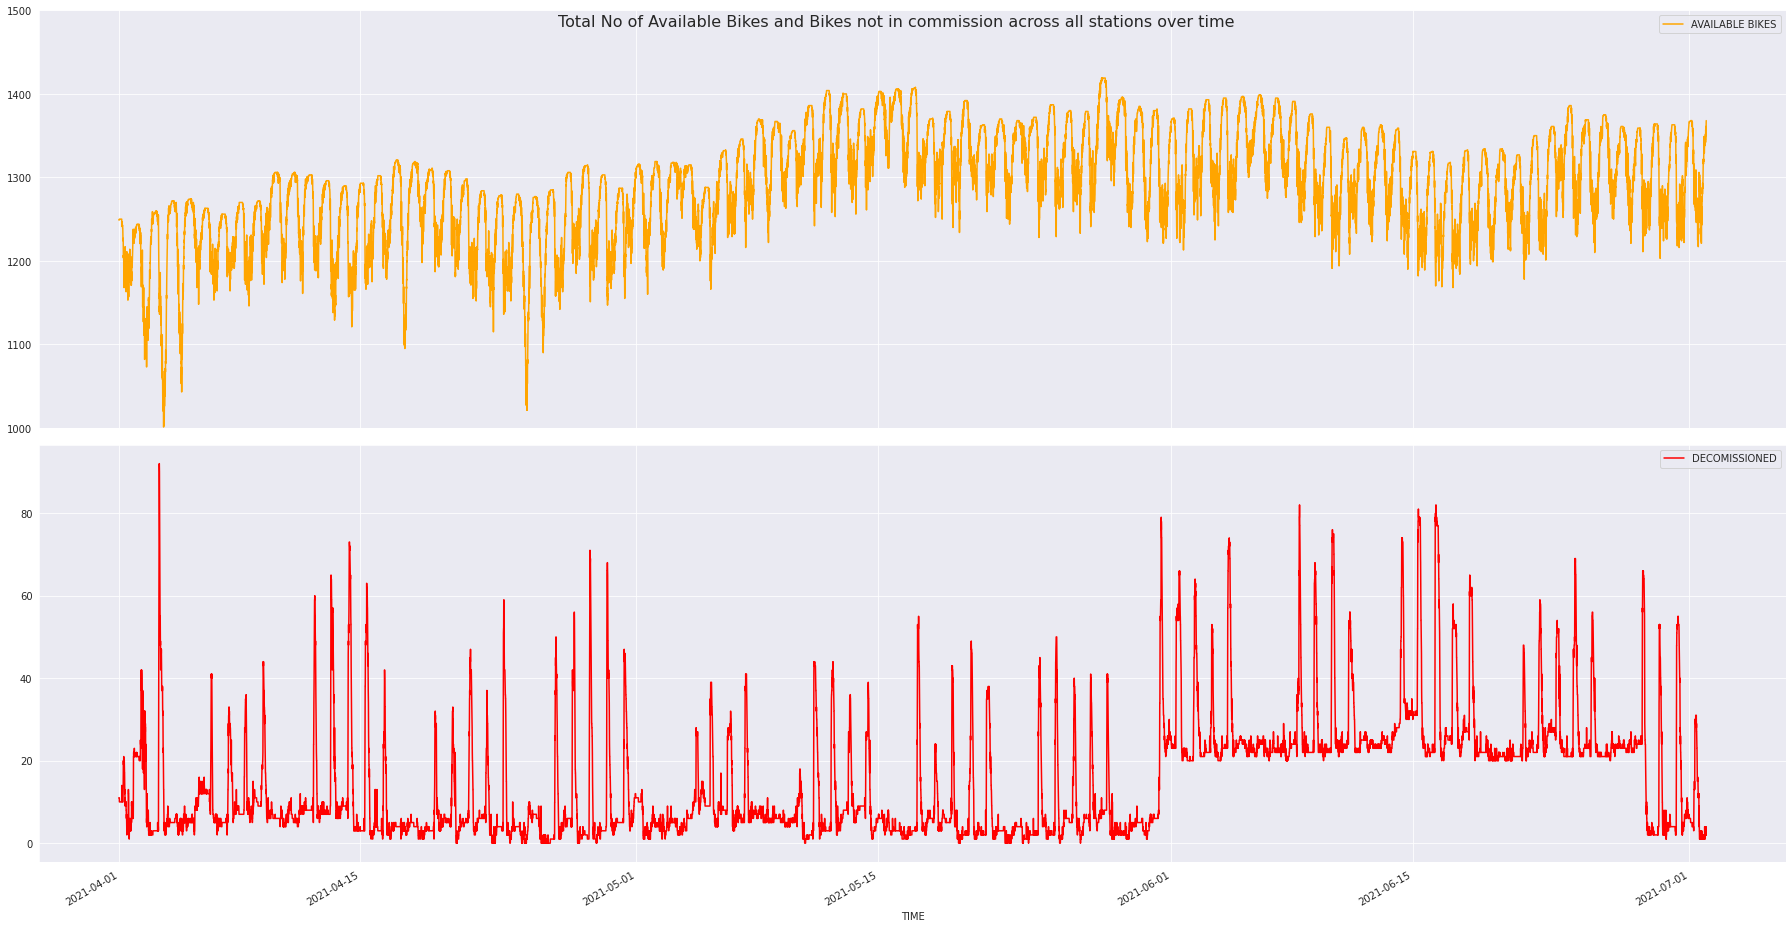

In [18]:


from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig.suptitle('Total No of Available Bikes and Bikes not in commission across all stations over time', fontsize=16)
ax1.set_ylim([1000,1500])
decomisisoned_daily = df[['STATION ID','TIME','DECOMISSIONED']].groupby('TIME').sum().reset_index()

#active_bikes = active_bikes.resample('H').first()
df.plot('TIME','AVAILABLE BIKES', ax = ax1,color = 'orange')
decomisisoned_daily.plot('TIME', 'DECOMISSIONED', ax = ax2, color = 'red')
plt.show()




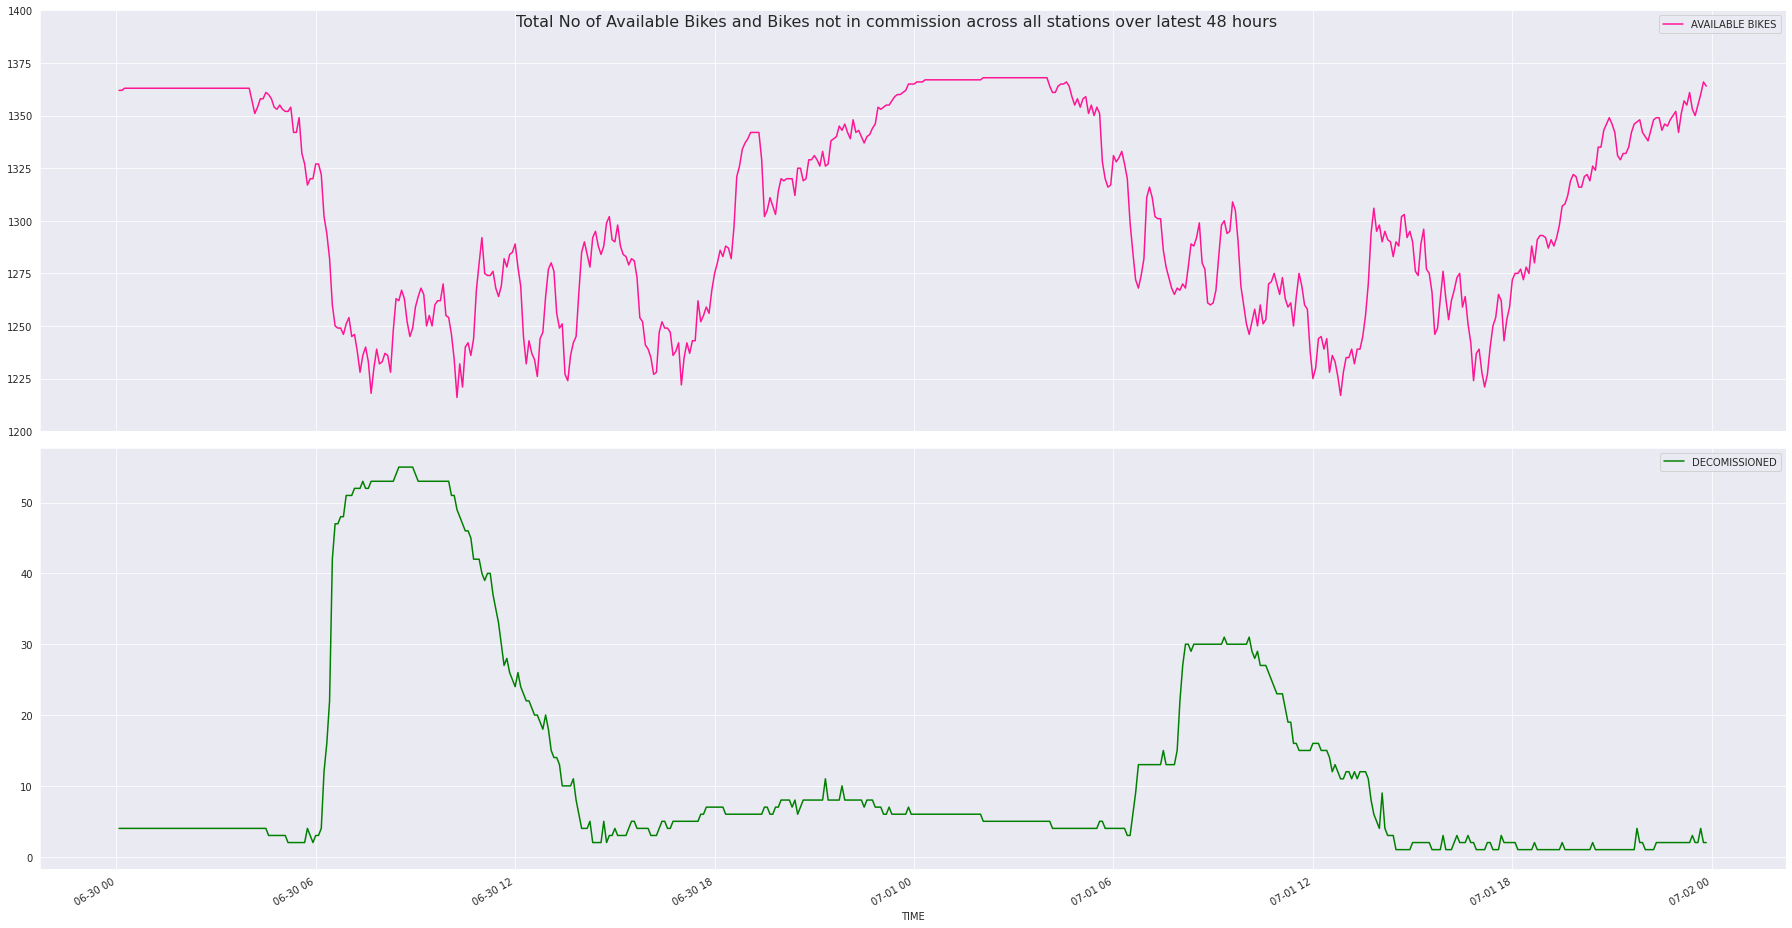

In [19]:
# Looking at the variability in available bikes across a dya
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig2, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig2.suptitle('Total No of Available Bikes and Bikes not in commission across all stations over latest 48 hours', fontsize=16)

df_latest48 = subset_dataframe(df,'2021-06-30 00:01:00') 
decomisisoned_daily = df_latest48[['STATION ID','TIME','DECOMISSIONED']].groupby('TIME').sum().reset_index()
ax1.set_ylim([1200,1400])

df_latest48.plot('TIME','AVAILABLE BIKES', ax = ax1,color = 'deeppink')
decomisisoned_daily.plot('TIME', 'DECOMISSIONED', ax = ax2, color = 'green')
plt.show()



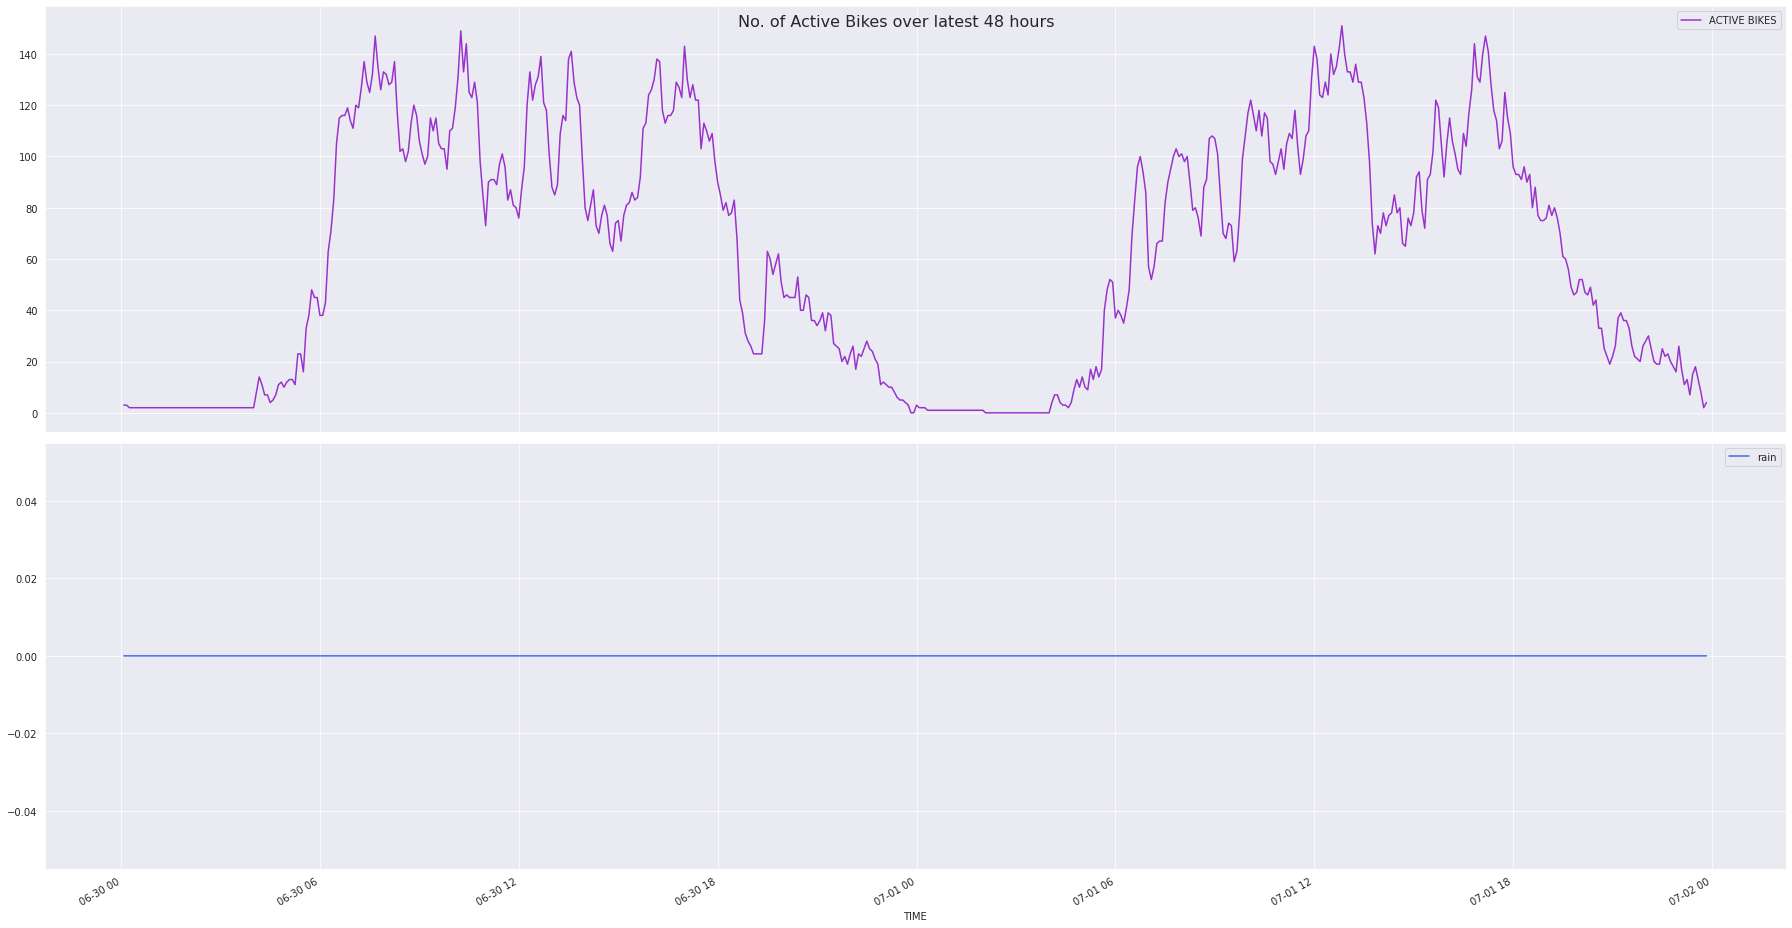

In [20]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig3, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig3.suptitle('No. of Active Bikes over latest 48 hours', fontsize=16)

last48hrs = subset_dataframe(df,'2021-06-30 00:01:00')

last48hrs.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
last48hrs.plot('TIME','rain', ax = ax2, color = 'royalblue')
plt.show()


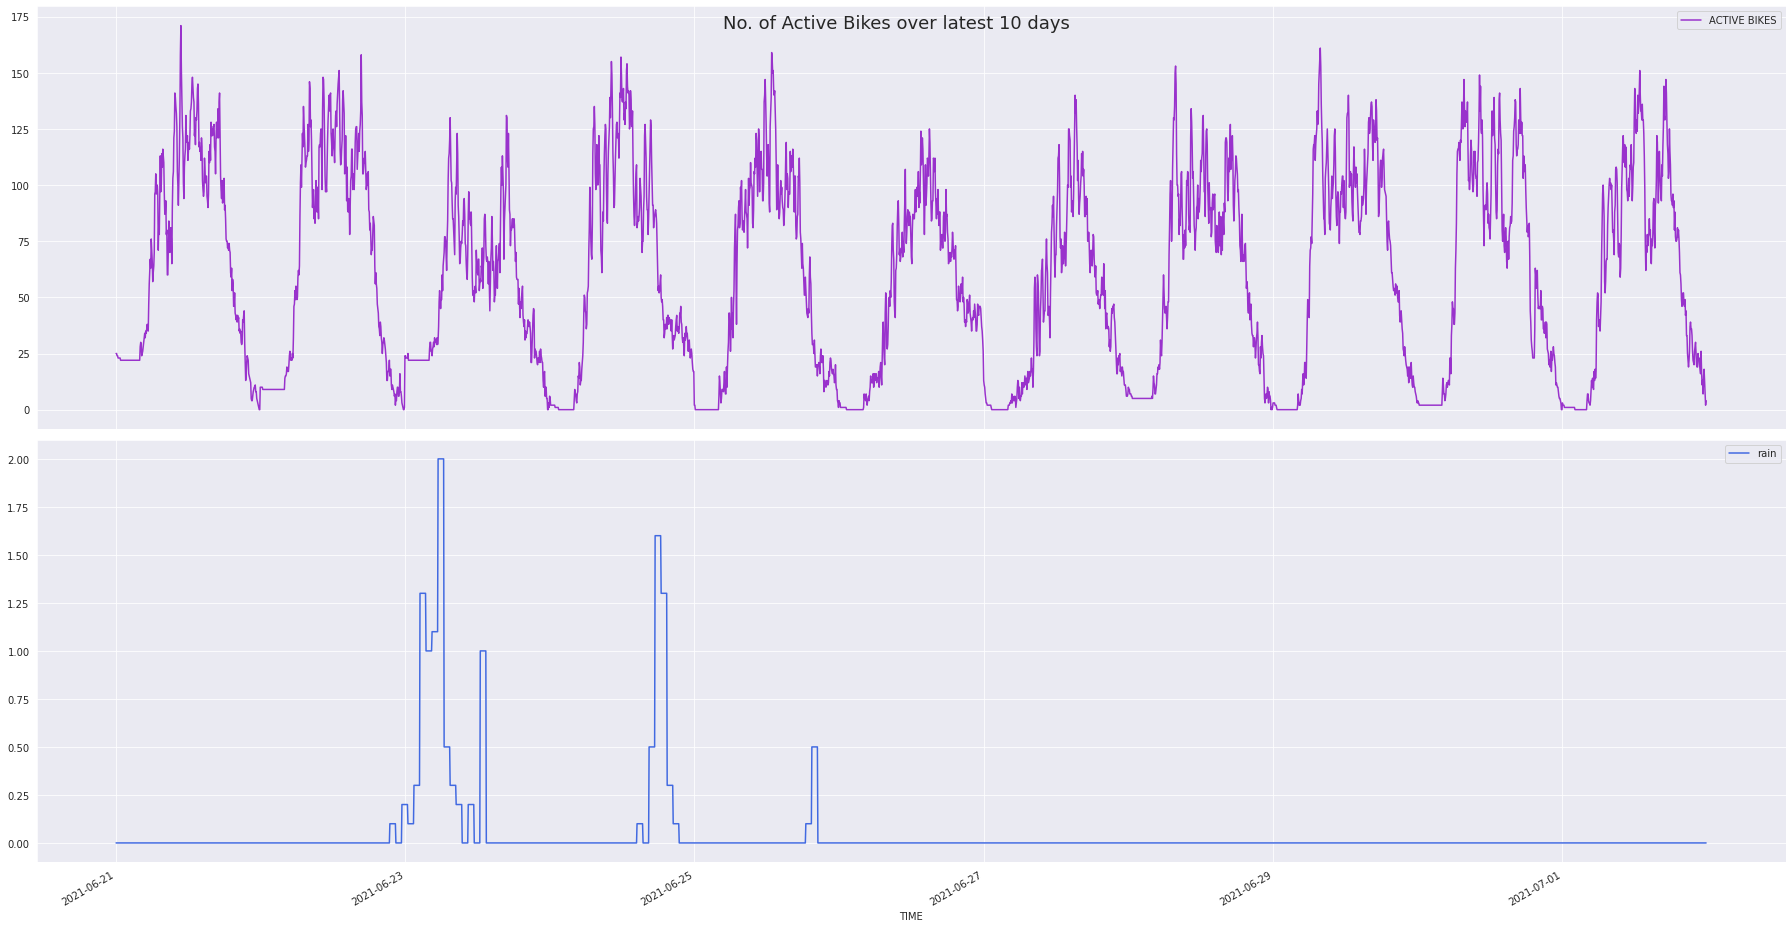

In [21]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig5, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig5.suptitle('No. of Active Bikes over latest 10 days', fontsize=18)

last10days = subset_dataframe(df,'2021-06-21 00:01:00')

last10days.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
last10days.plot('TIME','rain', ax = ax2, color = 'royalblue')
plt.show()


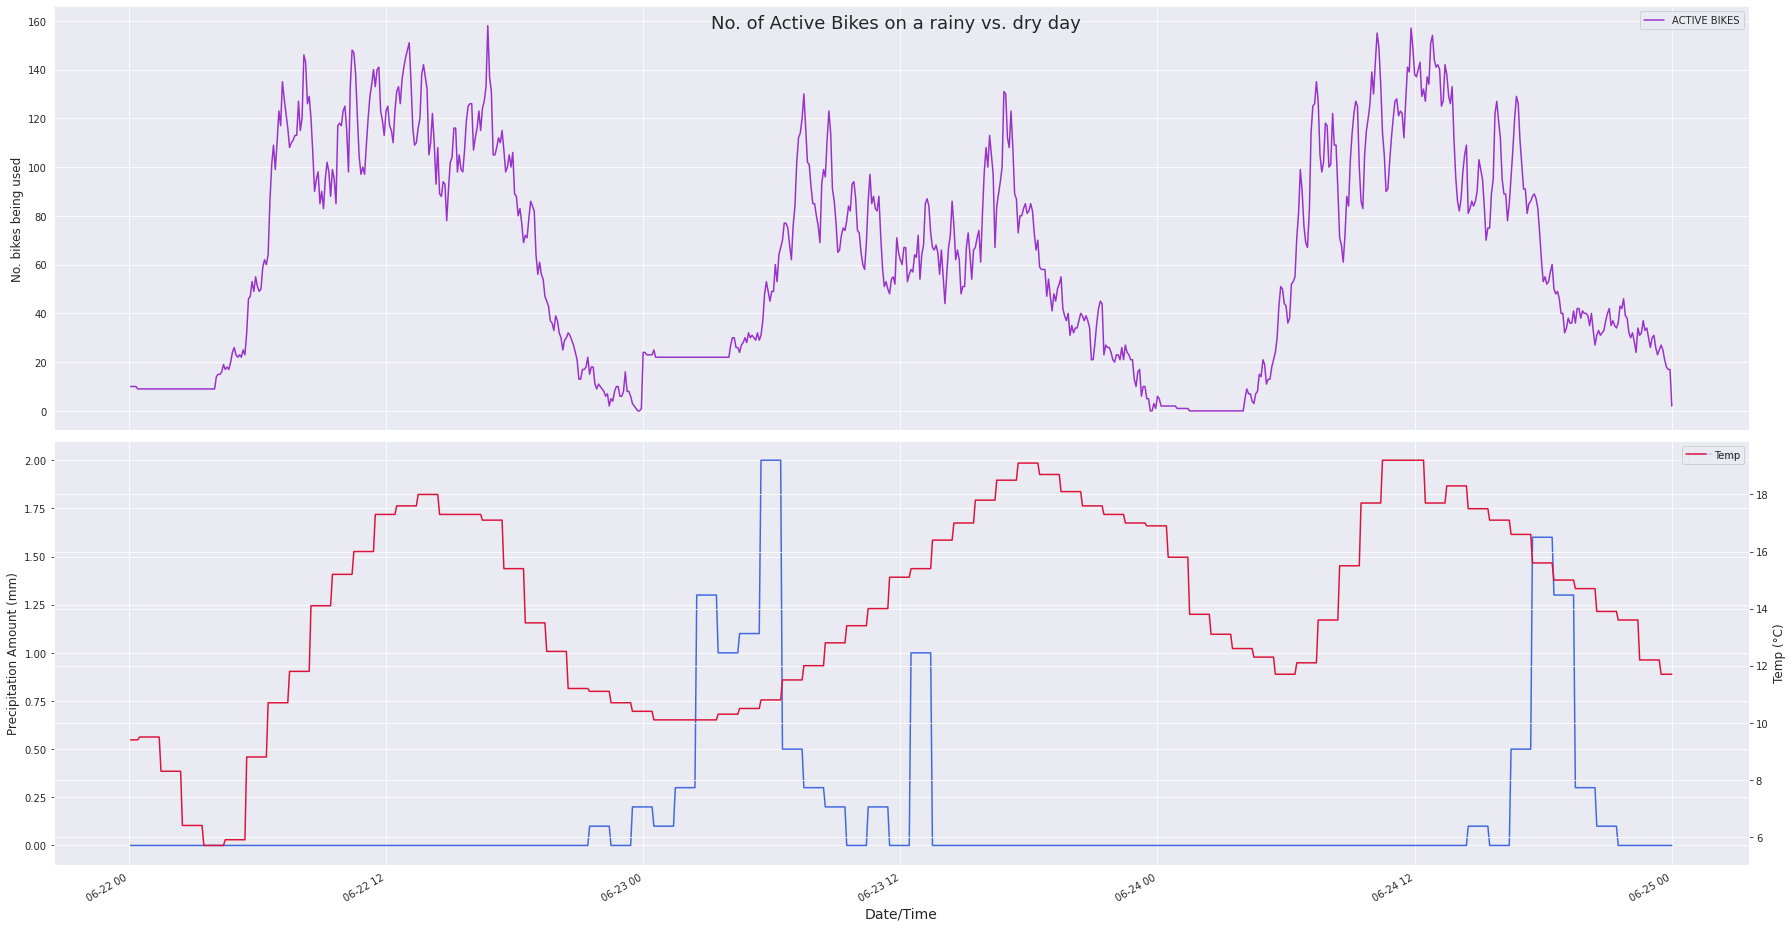

In [22]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig6, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig6.suptitle('No. of Active Bikes on a rainy vs. dry day', fontsize=18)

rainy_period = subset_dataframe(df,'2021-06-22 00:01:00','2021-06-25 00:01:00')                                      

#ax1.set_ylim([1200,1400])

rainy_period.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
rainy_period.plot('TIME','rain', ax = ax2, color = 'royalblue')
ax3 = ax2.twinx()
rainy_period.plot('TIME','temp', ax = ax3, color = 'crimson', label = 'Temp')

ax2.set_xlabel('Date/Time', fontsize = 14)
ax1.set_ylabel('No. bikes being used', fontsize = 12)
ax2.set_ylabel('Precipitation Amount (mm)', fontsize = 12)
ax3.set_ylabel('Temp (°C)', fontsize = 12)
plt.show()


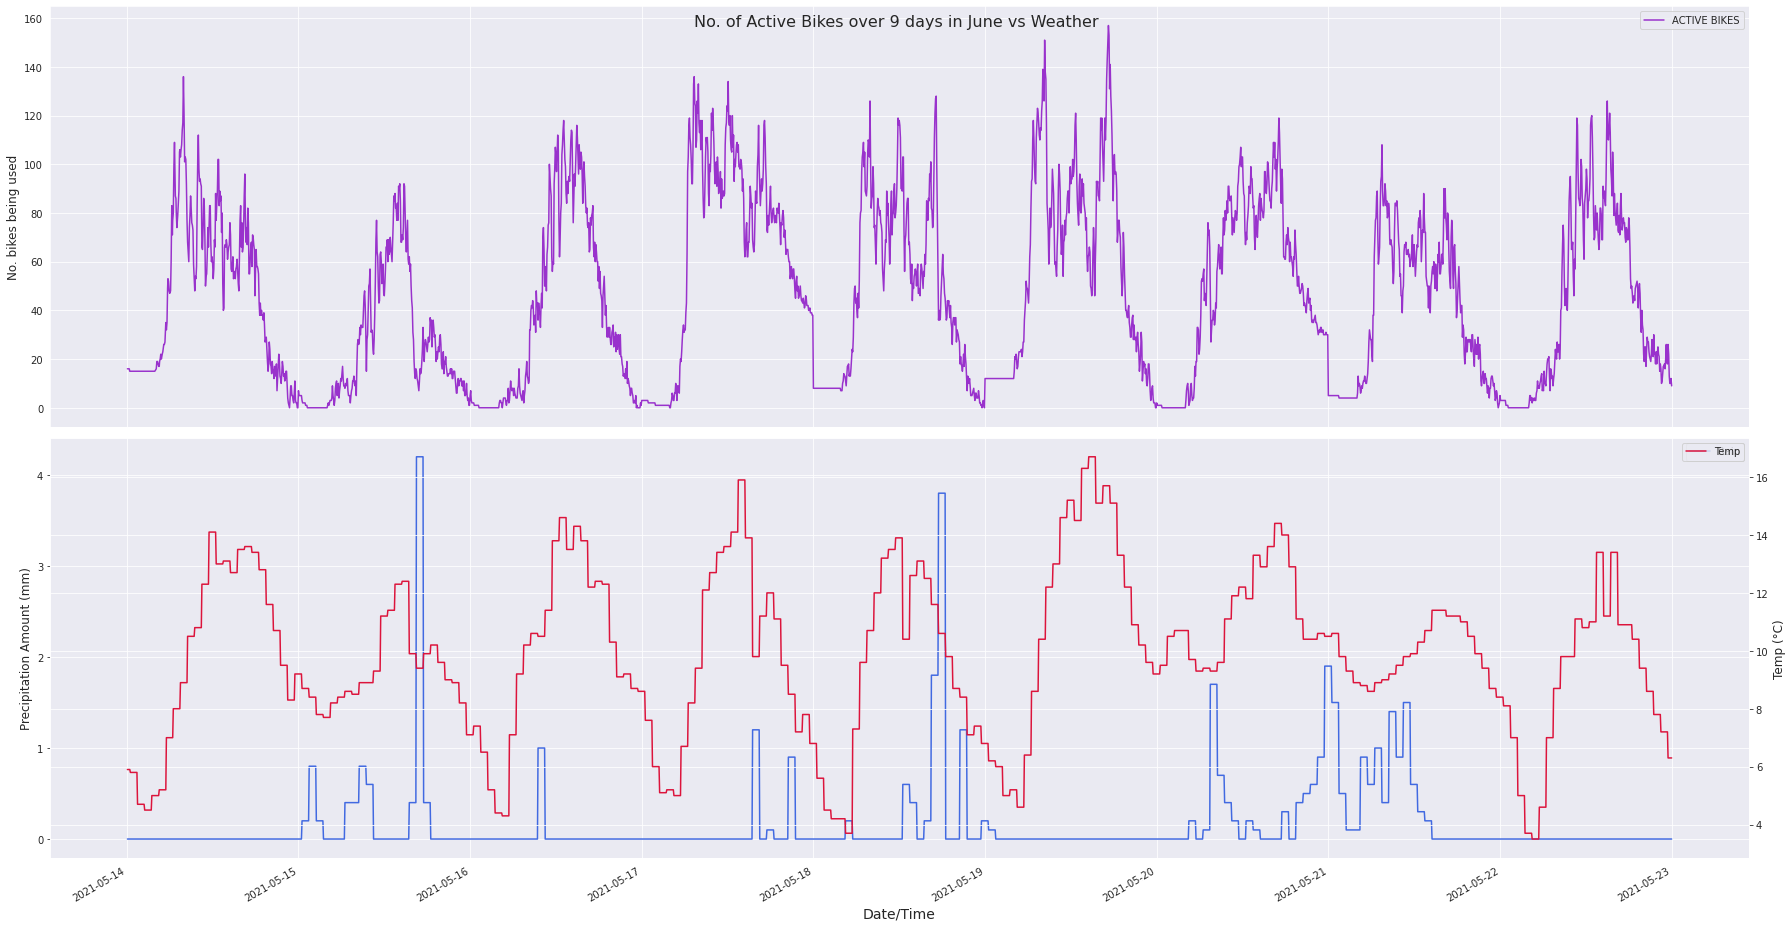

In [23]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig8, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig8.suptitle('No. of Active Bikes over 9 days in June vs Weather', fontsize=16)

rainy_days_june = subset_dataframe(df,'2021-05-14 00:01:00', '2021-05-23 00:01:00') 

#ax1.set_ylim([1200,1400])

rainy_days_june.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
rainy_days_june.plot('TIME','rain', ax = ax2, color = 'royalblue', label = 'Rain')
ax3 = ax2.twinx()
rainy_days_june.plot('TIME','temp', ax = ax3, color = 'crimson', label = 'Temp')

ax2.set_xlabel('Date/Time', fontsize = 14)
ax1.set_ylabel('No. bikes being used', fontsize = 12)
ax2.set_ylabel('Precipitation Amount (mm)', fontsize = 12)
ax3.set_ylabel('Temp (°C)', fontsize = 12)
plt.show()

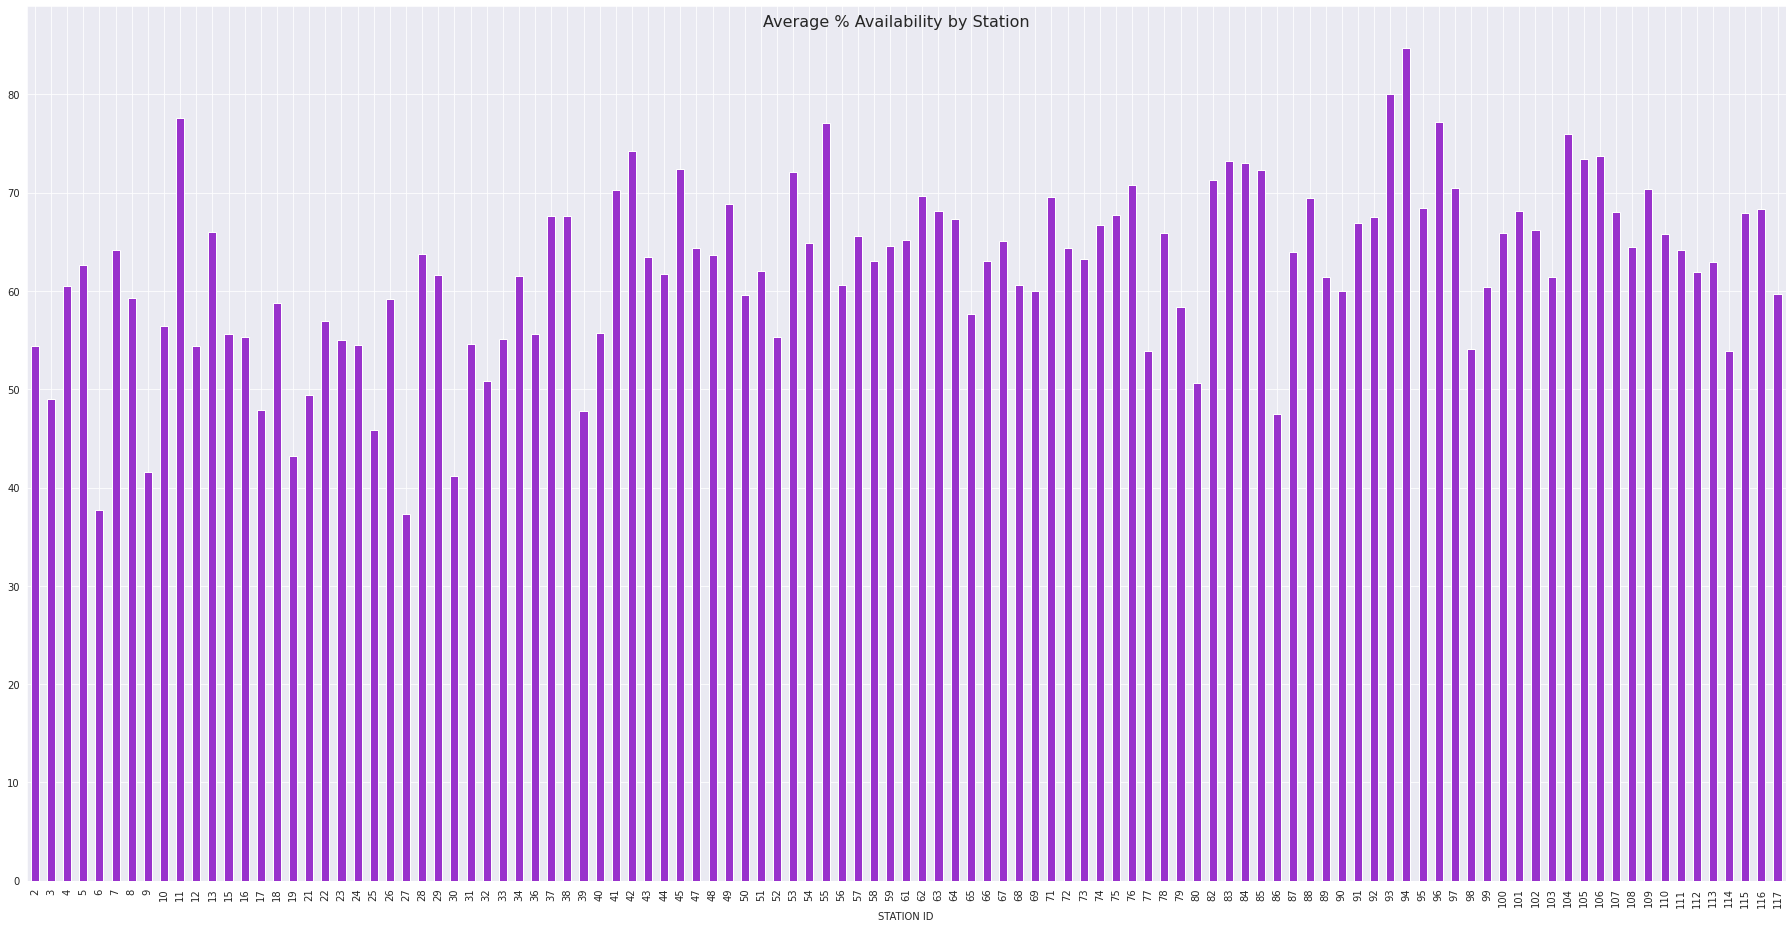

In [24]:
Avg_Station_Availability = df.groupby('STATION ID')['STATION AVAILABILITY'].mean()

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig3, ax = plt.subplots( figsize = (25,13), sharex = True, tight_layout = True)
fig3.suptitle('Average % Availability by Station', fontsize=16)

#ax1.set_ylim([1200,1400])

Avg_Station_Availability.plot.bar( ax = ax, color = 'darkorchid')
plt.show()


In [25]:
Geo_Station_Availability = df[['STATION ID','LATITUDE','LONGITUDE','STATION AVAILABILITY']].groupby('STATION ID').agg({'STATION ID':'first', 'STATION AVAILABILITY':'mean', 'LATITUDE':'first', 'LONGITUDE':'first'}).sort_values(by='STATION AVAILABILITY', ascending = False).reset_index(drop=True)
print(Geo_Station_Availability)

     STATION ID  STATION AVAILABILITY   LATITUDE  LONGITUDE
0            94             84.715805  53.346985  -6.297804
1            93             80.065163  53.346603  -6.296924
2            11             77.601604  53.334019  -6.258371
3            96             77.158566  53.341805  -6.305085
4            55             77.131153  53.334030  -6.260714
..          ...                   ...        ...        ...
104          19             43.211768  53.334431  -6.245575
105           9             41.609752  53.343033  -6.263578
106          30             41.205484  53.353462  -6.265305
107           6             37.723549  53.343369  -6.270120
108          27             37.343750  53.341290  -6.258117

[109 rows x 4 columns]


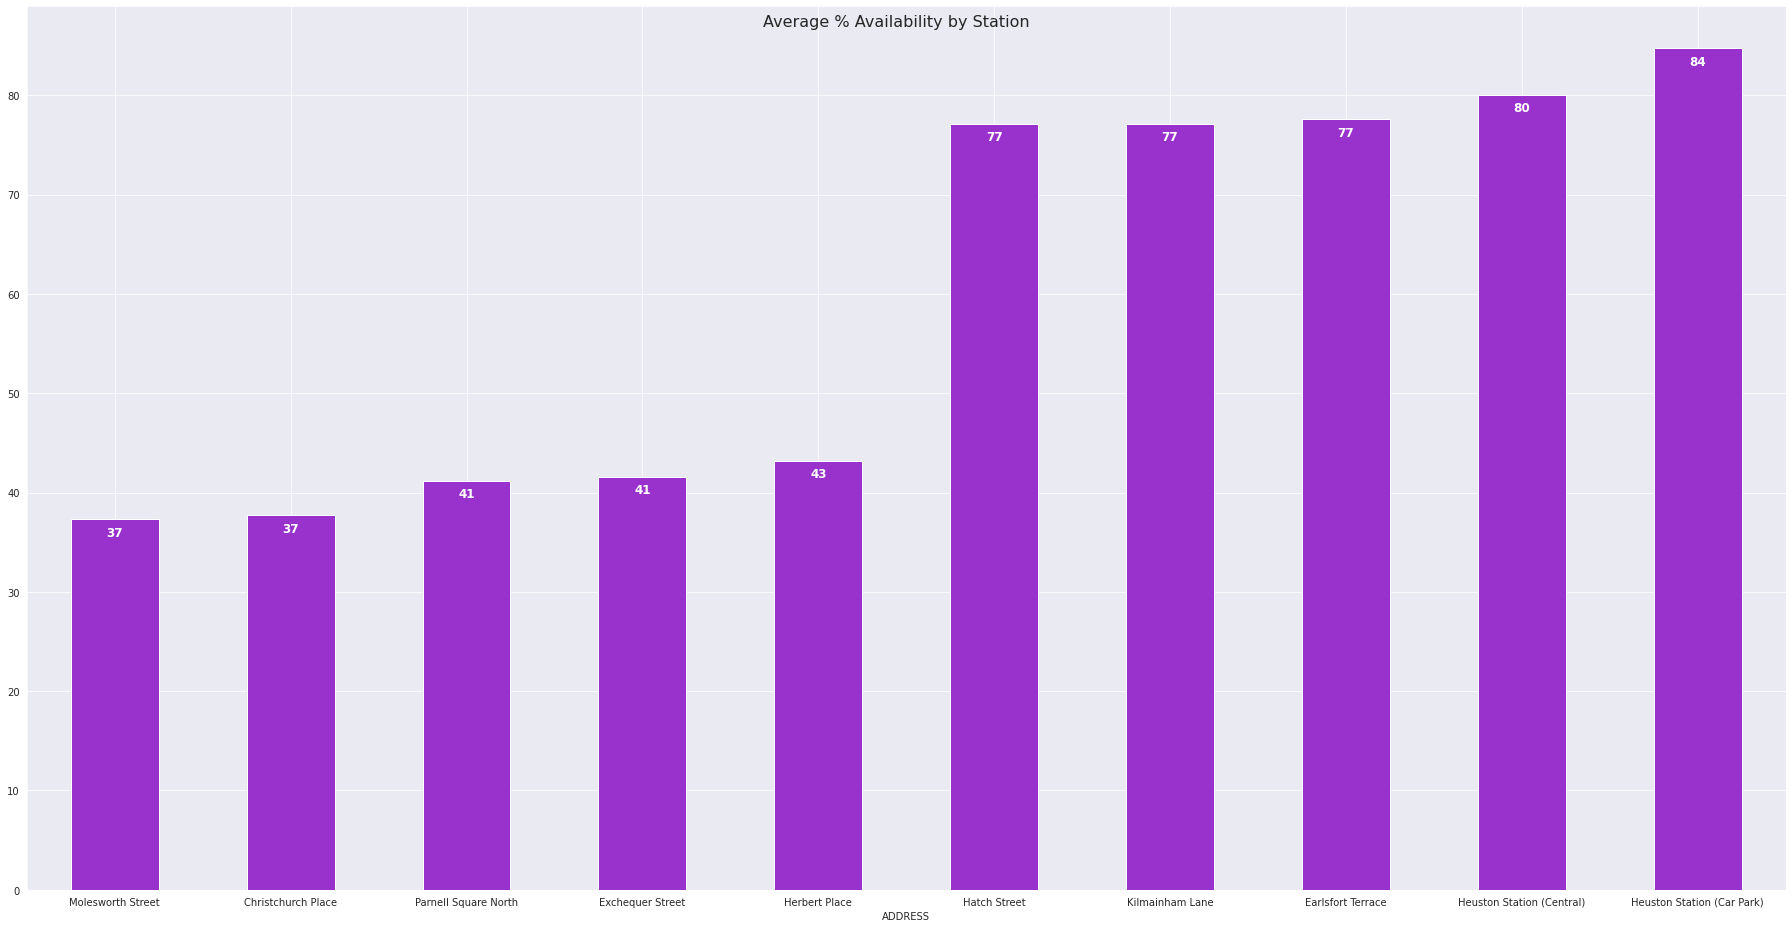

In [26]:
stationsOfInterest = subset_stationID(df, [94,93,11,96,55,19,9,30,6,27])

Avg_Station_Availability = stationsOfInterest.groupby('ADDRESS')['STATION AVAILABILITY'].mean().sort_values()

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig3, ax = plt.subplots( figsize = (25,13), sharex = True, tight_layout = True)
fig3.suptitle('Average % Availability by Station', fontsize=16)
Avg_Station_Availability.plot.bar( ax = ax, color = 'darkorchid')
plt.xticks(rotation=0)
rects = ax.patches

# Make some labels.
labels = Avg_Station_Availability.astype(int)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height - 2, label, ha="center", va="bottom", color='white', fontsize=12, weight = 'bold'
    )
plt.show()

In [27]:
Avg_Station_Availability = df.groupby('ADDRESS')['STATION AVAILABILITY'].mean().sort_values()

In [28]:
ROI_map= gpd.read_file('/content/gdrive/MyDrive/Bike Share/ie_10km.shp') 

NameError: ignored

In [ ]:
ROI_map

In [ ]:
ActivityByDay = df.groupby([df['TIME'].dt.day_name(),'TIME'])['ACTIVE BIKES'].mean()
ActivityByDay.index.names=['Day of Week','TIME']
Mon = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == 'Monday'].droplevel(0))

In [ ]:
fig10,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig10.suptitle('No. of Active Bikes over Monday 28th June 2021', fontsize=16)
Mon = Mon.reset_index()
Mon['TIME'] = pd.to_datetime(Mon['TIME'])
Mon['date'] = Mon['TIME'].dt.date
Mon['TIME'] = Mon['TIME'].dt.time
Mon = Mon[Mon['date'] == Mon['date'].max()]
Mon.plot( ax = ax, color = 'darkorchid')

In [ ]:
daysofweek = list(ActivityByDay.index.get_level_values(0).unique())
fig10,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig10.suptitle('No. of Active Bikes over Week beginning 28/06/2021 by day of week', fontsize=16)

for day in daysofweek:
  
  day = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == day].droplevel(0),name=day)
  day = day.reset_index()
  day['date'] = day['TIME'].dt.date
  day['TIME'] = day['TIME'].dt.time
  day = day[day['date'] == day['date'].max()]
  day.plot(x= 'TIME', ax = ax)


In [ ]:
daysofweek = list(ActivityByDay.index.get_level_values(0).unique())
fig10,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig10.suptitle('No. of Active Bikes over Week beginning 28/06/2021 by day of week', fontsize=16)

for day in daysofweek:
  
  day = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == day].droplevel(0),name=day)
  day = day.resample('1H').median()
  day = day.reset_index()
  day['date'] = day['TIME'].dt.date
  day['TIME'] = day['TIME'].dt.time
  day = day[day['date'] == day['date'].max()]
  day.plot(x= 'TIME', ax = ax)



In [ ]:
daysofweek = list(ActivityByDay.index.get_level_values(0).unique())
fig12,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig12.suptitle('Average No. of Active Dublin Bikes by day of week', fontsize=16)

for day in daysofweek:
  
  day = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == day].droplevel(0),name=day)
  day = day.resample('1H').mean()
  day = day.reset_index()
  day['date'] = day['TIME'].dt.date
  day['TIME'] = day['TIME'].dt.time
  day = day.groupby('TIME').mean()
  day.plot( ax = ax)


In [ ]:
df['rainy day'] = df['rain'] > 0

In [ ]:
rainyDays = df[df['rainy day']==True]
dryDays = df[df['rainy day']==False]
print('Proportion of rainy days = \n ', rainyDays.shape[0]/(rainyDays.shape[0]+dryDays.shape[0]))

In [ ]:
DryDaysbyWeekday = get_activity_by_day(dryDays)

daysofweek = list(DryDaysbyWeekday.index.get_level_values(0).unique())
fig12,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig12.suptitle('Average No. of Active Dublin Bikes by day of week (dry days only)', fontsize=16)

for day in daysofweek:
  
  day = pd.Series(DryDaysbyWeekday.iloc[DryDaysbyWeekday.index.get_level_values('Day of Week') == day].droplevel(0),name=day)
  day = day.resample('1H').mean()
  day = day.reset_index()
  day['date'] = day['TIME'].dt.date
  day['TIME'] = day['TIME'].dt.time
  day = day.groupby('TIME').mean()
  day.plot( ax = ax)

In [ ]:
print(df)